In [1]:
!pip install ultralytics
from ultralytics import YOLO
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 633.3 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.1/872.1 kB 5.9 MB/s eta 0:00:0000:0100:01


In [2]:
# Lấy đường dẫn đến các file Calib
calib_files = sorted(glob.glob("/data/calib/*.txt"))
print("các file calib: ", calib_files)


# Đọc thử file thứ 1
index = 1
file_name = calib_files[index]
print("Đọc file: ", file_name)


print("Nội dung file: \n", open(file_name).read())

'''
THÔNG TIN Calibration file của tập dữ liệu KITTI
    Tham khảo: 
      - https://medium.com/@abdulhaq.ah/kitti-calibration-file-explained-p0-3-r0-rect-tr-velo-to-cam-and-tr-imu-to-velo-fb47b3f254e6 
      - https://www.cvlibs.net/datasets/kitti/setup.php
      - https://medium.com/test-ttile/kitti-3d-object-detection-dataset-d78a762b5a4
      - https://stackoverflow.com/questions/58918538/how-kitti-calibration-matrix-was-calculated


Ảnh mức xám (không dùng)
- P0: projection matrix của left camera
- P1: projection matrix của right camera

Ảnh màu (dùng): baseline là 0.54
- P2: projection matrix của left camera
- P3: projection matrix của right camera

Thông tin khác (không dùng)
- R0_rect: Rectification Matrix
- Tr_velo_to_cam: Transformation Matrix - Velodyne Lidar to Camera
- Tr_imu_to_velo: Transformation Matrix - IMU to Velodyne Lidar
'''

def get_calibration_parameters(file):
    with open(file, 'r') as f:
        fin = f.readlines()
        for line in fin:
            if line[:2] == 'P2':
                p_left = np.array(line[4:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:2] == 'P3':
                p_right = np.array(line[4:].strip().split(" ")).astype('float32').reshape(3,-1)

    return p_left, p_right

các file calib:  ['/kaggle/input/data-cd5/data/calib/000007.txt', '/kaggle/input/data-cd5/data/calib/000008.txt', '/kaggle/input/data-cd5/data/calib/000009.txt', '/kaggle/input/data-cd5/data/calib/000010.txt', '/kaggle/input/data-cd5/data/calib/000013.txt', '/kaggle/input/data-cd5/data/calib/000050.txt']
Đọc file:  /kaggle/input/data-cd5/data/calib/000008.txt
Nội dung file: 
 P0: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 0.000000000000e+00 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 0.000000000000e+00 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 0.000000000000e+00
P1: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 -3.875744000000e+02 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 0.000000000000e+00 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 0.000000000000e+00
P2: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 4.485728000000e+01 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 2.163791000000e-01 

In [3]:
p_left, p_right = get_calibration_parameters(calib_files[index])
print("left projection matrix: \n", p_left)
print("right projection matrix: \n", p_right)


'''
Projection matrix (P): có kích thước 3x4, P gồm có 3 ma trận P = K[R|T]
    Trong đó:
        - P: Projection matrix gồm có 
            + K: Camera intrinsic matrix
            + R: Rotation matrix
            + T: Translation matrix 
    Tham khảo: 
        - https://stackoverflow.com/questions/58918538/how-kitti-calibration-matrix-was-calculated

  p = [ 
        [fu 0   cx  -fu*bx],
        [0  fv  cy  -fv*by],
        [0  0   1   0]
      ]
ví dụ:
     [
        [7.215377e+02 0.000000e+00 6.095593e+02 4.485728e+01]
        [0.000000e+00 7.215377e+02 1.728540e+02 2.163791e-01]
        [0.000000e+00 0.000000e+00 1.000000e+00 2.745884e-03]
    ]
'''

def decompose_projection_matrix(p):
    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)
    print("k: \n", k)
    print("r: \n", r)
    print("t: \n", t)
    t = t / t[3]        
    return k, r, t

k_left, r_left, t_left = decompose_projection_matrix(p_left)
k_right, r_right, t_right = decompose_projection_matrix(p_right)

left projection matrix: 
 [[     721.54           0      609.56      44.857]
 [          0      721.54      172.85     0.21638]
 [          0           0           1   0.0027459]]
right projection matrix: 
 [[     721.54           0      609.56     -339.52]
 [          0      721.54      172.85      2.1999]
 [          0           0           1   0.0027299]]
k: 
 [[     721.54           0      609.56]
 [          0      721.54      172.85]
 [          0           0           1]]
r: 
 [[          1           0           0]
 [          0           1           0]
 [          0           0           1]]
t: 
 [[  -0.059742]
 [ 0.00035729]
 [  -0.002741]
 [    0.99821]]
k: 
 [[     721.54           0      609.56]
 [          0      721.54      172.85]
 [          0           0           1]]
r: 
 [[          1           0           0]
 [          0           1           0]
 [          0           0           1]]
t: 
 [[    0.42748]
 [ -0.0021651]
 [ -0.0024679]
 [    0.90402]]


In [4]:
print("k_left \n", k_left)
print("\nr_left \n", r_left)
print("\nt_left \n", t_left)

# focal length
focal_length = k_left[0,0]

# baseline
baseline = abs(t_left[0] - t_right[0])

print("focal_length: \n", focal_length)
print("baseline: \n", baseline)

k_left 
 [[     721.54           0      609.56]
 [          0      721.54      172.85]
 [          0           0           1]]

r_left 
 [[          1           0           0]
 [          0           1           0]
 [          0           0           1]]

t_left 
 [[  -0.059849]
 [ 0.00035793]
 [ -0.0027459]
 [          1]]
focal_length: 
 721.5377
baseline: 
 [    0.53271]


In [5]:
# Disparity map
def compute_disparity_map(left_image, right_image, sad_window, block_size):
    """
    Tính toán bản đồ chênh lệch (disparity map) từ cặp ảnh trái-phải và thông tin hiệu chỉnh.

    Args:
        left_image (numpy.ndarray): Ảnh trái.
        right_image (numpy.ndarray): Ảnh phải.
        sad_window (int): Kích thước cửa sổ SAD (Tổng chênh lệch tuyệt đối).
        block_size (int): Kích thước khối.

    Returns:
        numpy.ndarray: Bản đồ chênh lệch.
    """

    img_left_gray = cv2.cvtColor(left_image, cv2.COLOR_BGR2GRAY)
    img_right_gray = cv2.cvtColor(right_image, cv2.COLOR_BGR2GRAY)

    sgbm = cv2.StereoSGBM_create(
        numDisparities=sad_window * 16,
        minDisparity=0,
        blockSize=block_size,
        P1=8 * 3 * sad_window**2,
        P2=32 * 3 * sad_window**2,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
    )

    disparity = sgbm.compute(img_left_gray, img_right_gray)
    disparity = disparity / 16 

    return disparity

In [18]:
model = YOLO("/model/yolov8s.pt")

left_image = cv2.imread("/data/video - kitti/video - kitti/image_02/data/0000000335.png")
right_image = cv2.imread("/data/video - kitti/video - kitti/image_03/data/0000000335.png")

100%|██████████| 21.5M/21.5M [00:00<00:00, 122MB/s] 


In [19]:
# StereoSGBM
sad_window = 5
block_size = 15
disparity_sgbm = compute_disparity_map(left_image, right_image, sad_window, block_size)
disparity_sgbm[disparity_sgbm == -1] = 0.1 
depth_map_sgbm = (focal_length * baseline) / disparity_sgbm

/tmp/ipykernel_34/2312512558.py:6: RuntimeWarning: divide by zero encountered in divide
  depth_map_sgbm = (focal_length * baseline) / disparity_sgbm


In [20]:
# YOLOv8
results = model.predict(source="/data/video - kitti/video - kitti/image_02/data/0000000335.png")
boxes = results[0].boxes.xyxy.cpu().numpy()  


image 1/1 /kaggle/input/data-cd5/data/video - kitti/video - kitti/image_02/data/0000000335.png: 224x640 2 persons, 2 cars, 1 truck, 61.8ms
Speed: 1.2ms preprocess, 61.8ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 640)


In [21]:
# Tính độ sâu cho mỗi bbox
for b in boxes:
    x1, y1, x2, y2 = b.astype(int)

    depth_region = depth_map_sgbm[y1:y2, x1:x2]

    depth_min = np.min(depth_region)
    depth_mean = np.mean(depth_region)
    depth_median = np.median(depth_region)

    cv2.rectangle(left_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(left_image, f"Min: {depth_min:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    cv2.putText(left_image, f"Mean: {depth_mean:.2f}", (x1, y1 - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    cv2.putText(left_image, f"Median: {depth_median:.2f}", (x1, y1 - 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

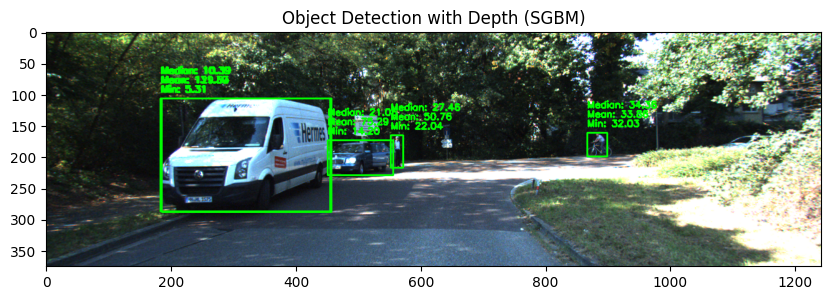

In [22]:
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB))
plt.title("Object Detection with Depth (SGBM)")
plt.show()

In [23]:
import glob

width = 1242
height = 375

# cv2.namedWindow("left")
# cv2.moveWindow("left", 0, 0)

# cv2.namedWindow("right")
# cv2.moveWindow("right", 0, height+30)

left_video = sorted(glob.glob("/data/video - kitti/video - kitti/image_02/data/*.png"))
right_video = sorted(glob.glob("/data/video - kitti/video - kitti/image_03/data/*.png"))

In [24]:
if len(left_video) == 0 or len(right_video) == 0:
    print("Không tìm thấy ảnh trong thư mục")
    exit()

In [25]:
left_img = cv2.imread(left_video[0])
print(type(left_video), len(left_video), left_img.shape)

<class 'list'> 481 (375, 1242, 3)


In [26]:
sad_window = 5
block_size = 15
sgbm = cv2.StereoSGBM_create(
    numDisparities=sad_window * 16,
    minDisparity=0,
    blockSize=block_size,
    P1=8 * 3 * sad_window**2,
    P2=32 * 3 * sad_window**2,
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
)

k: 
 [[     721.54           0      609.56]
 [          0      721.54      172.85]
 [          0           0           1]]
r: 
 [[          1           0           0]
 [          0           1           0]
 [          0           0           1]]
t: 
 [[  -0.059742]
 [ 0.00035729]
 [  -0.002741]
 [    0.99821]]
k: 
 [[     721.54           0      609.56]
 [          0      721.54      172.85]
 [          0           0           1]]
r: 
 [[          1           0           0]
 [          0           1           0]
 [          0           0           1]]
t: 
 [[    0.42748]
 [ -0.0021651]
 [ -0.0024679]
 [    0.90402]]

image 1/1 /kaggle/input/data-cd5/data/video - kitti/video - kitti/image_02/data/0000000025.png: 224x640 1 car, 8.5ms
Speed: 1.3ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 224, 640)


/tmp/ipykernel_34/3585186781.py:30: RuntimeWarning: divide by zero encountered in divide
  depth_map = (focal_length * baseline) / disparity_sgbm


Frame 26 - Min: 4.87m - Max: infm


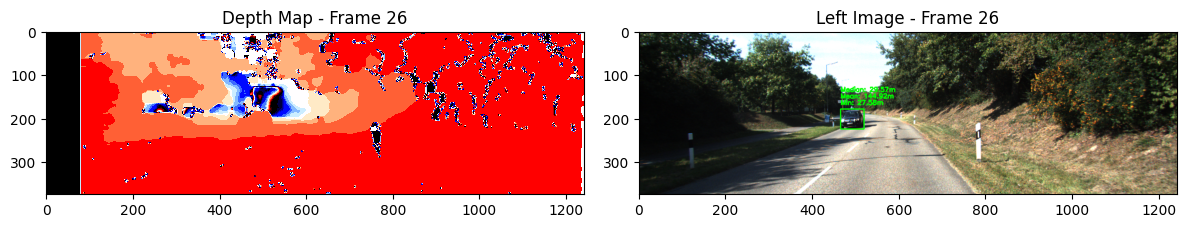


image 1/1 /kaggle/input/data-cd5/data/video - kitti/video - kitti/image_02/data/0000000026.png: 224x640 1 car, 1 parking meter, 8.7ms
Speed: 1.4ms preprocess, 8.7ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 640)
Frame 27 - Min: 4.87m - Max: infm


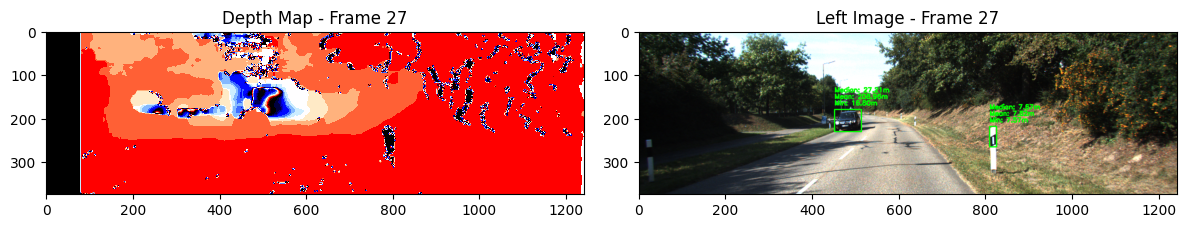


image 1/1 /kaggle/input/data-cd5/data/video - kitti/video - kitti/image_02/data/0000000027.png: 224x640 2 cars, 1 parking meter, 8.5ms
Speed: 1.3ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 224, 640)
Frame 28 - Min: 4.87m - Max: infm


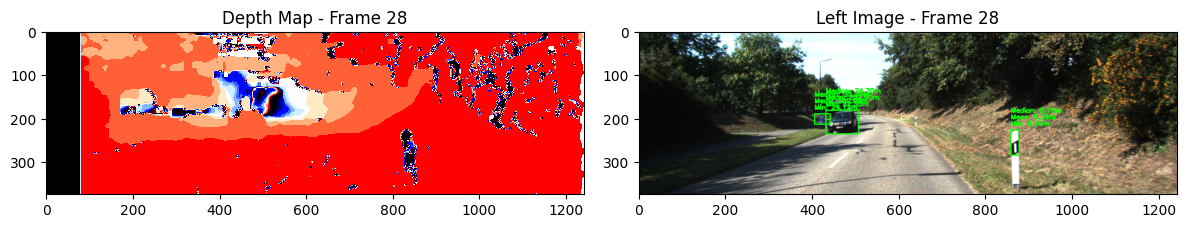


image 1/1 /kaggle/input/data-cd5/data/video - kitti/video - kitti/image_02/data/0000000028.png: 224x640 2 cars, 8.5ms
Speed: 1.3ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 224, 640)
Frame 29 - Min: 4.87m - Max: infm


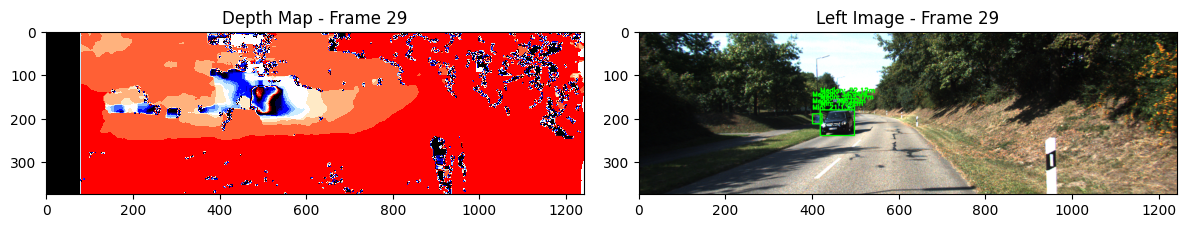


image 1/1 /kaggle/input/data-cd5/data/video - kitti/video - kitti/image_02/data/0000000029.png: 224x640 1 car, 8.5ms
Speed: 1.3ms preprocess, 8.5ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 640)
Frame 30 - Min: 4.87m - Max: infm


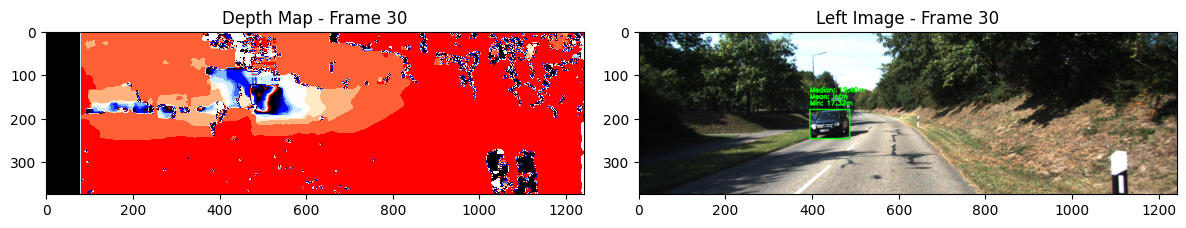


image 1/1 /kaggle/input/data-cd5/data/video - kitti/video - kitti/image_02/data/0000000030.png: 224x640 1 car, 8.5ms
Speed: 1.3ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 224, 640)
Frame 31 - Min: 4.87m - Max: infm


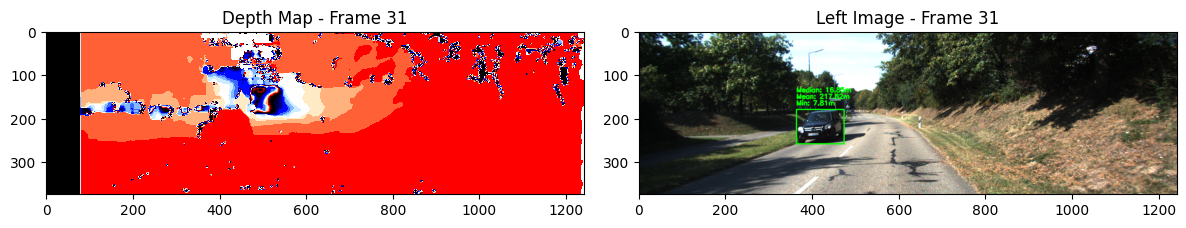


image 1/1 /kaggle/input/data-cd5/data/video - kitti/video - kitti/image_02/data/0000000031.png: 224x640 1 car, 8.4ms
Speed: 1.3ms preprocess, 8.4ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 640)
Frame 32 - Min: 4.87m - Max: infm


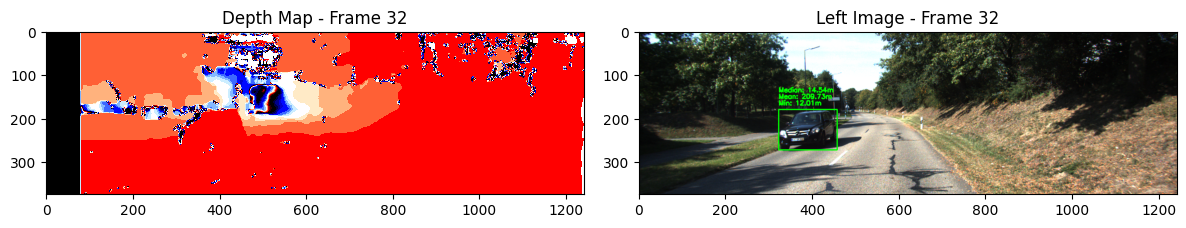


image 1/1 /kaggle/input/data-cd5/data/video - kitti/video - kitti/image_02/data/0000000032.png: 224x640 1 car, 8.5ms
Speed: 1.3ms preprocess, 8.5ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 640)
Frame 33 - Min: 4.87m - Max: infm


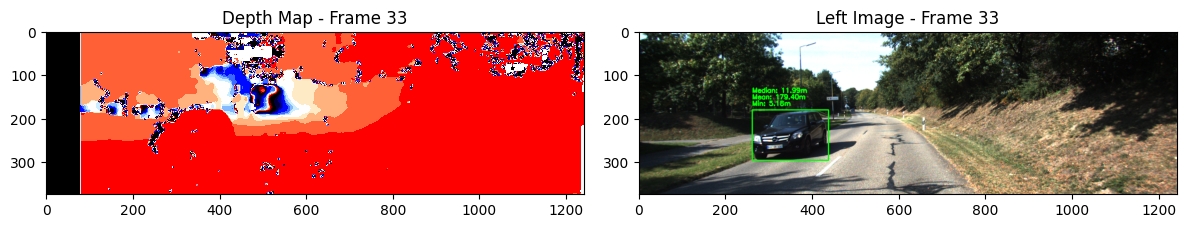


image 1/1 /kaggle/input/data-cd5/data/video - kitti/video - kitti/image_02/data/0000000033.png: 224x640 1 car, 8.7ms
Speed: 1.4ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 640)
Frame 34 - Min: 4.87m - Max: infm


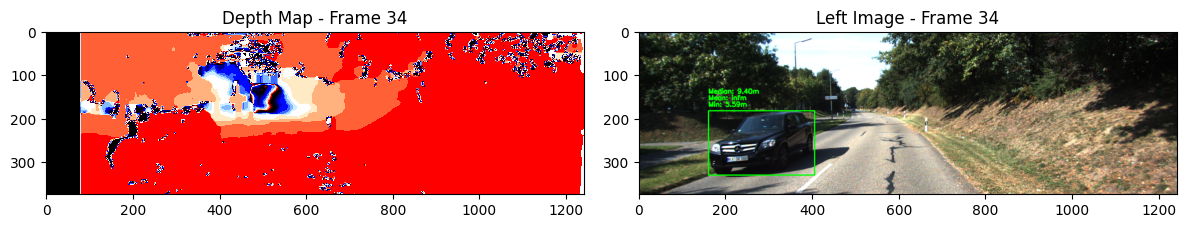


image 1/1 /kaggle/input/data-cd5/data/video - kitti/video - kitti/image_02/data/0000000034.png: 224x640 1 car, 8.6ms
Speed: 1.3ms preprocess, 8.6ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 640)
Frame 35 - Min: 4.87m - Max: infm


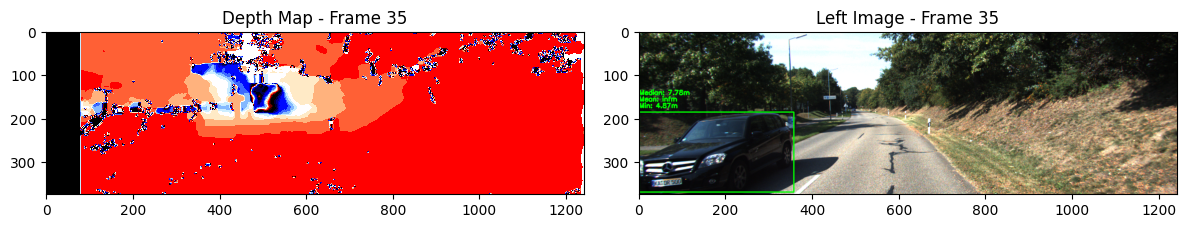


image 1/1 /kaggle/input/data-cd5/data/video - kitti/video - kitti/image_02/data/0000000035.png: 224x640 1 car, 8.4ms
Speed: 1.3ms preprocess, 8.4ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 640)
Frame 36 - Min: 4.87m - Max: infm


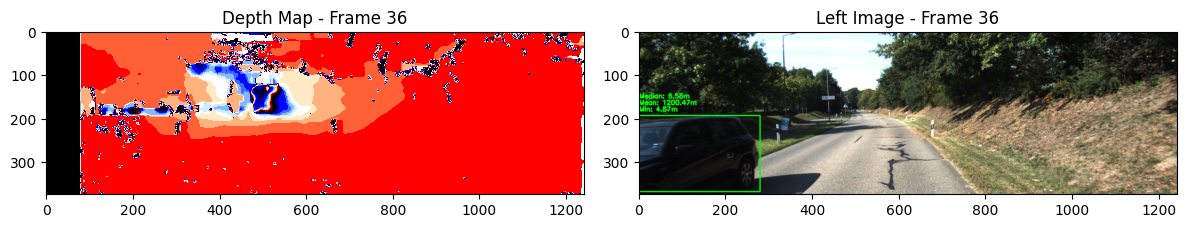

In [27]:
# Define the start and end frames for processing
start_frame = 25
end_frame = 35

# Get the calibration parameters from the calibration file
calib_files = sorted(glob.glob("data/calib/*.txt"))
p_left, p_right = get_calibration_parameters(calib_files[0])

# Decompose the projection matrices
k_left, r_left, t_left = decompose_projection_matrix(p_left)
k_right, r_right, t_right = decompose_projection_matrix(p_right)

# Get the focal length and baseline
focal_length = k_left[0, 0]
baseline = abs(t_left[0] - t_right[0])

# Loop through the frames
for i in range(start_frame, end_frame + 1):
    # Load the left and right images
    left_image_path = f"/data/video - kitti/video - kitti/image_02/data/0000000{i:03d}.png"
    right_image_path = f"/data/video - kitti/video - kitti/image_03/data/0000000{i:03d}.png"
    left_img = cv2.imread(left_image_path)
    right_img = cv2.imread(right_image_path)

    # Calculate the disparity map using StereoSGBM
    sad_window = 5
    block_size = 15
    disparity_sgbm = compute_disparity_map(left_img, right_img, sad_window, block_size)
    disparity_sgbm[disparity_sgbm == -1] = 0.1
    depth_map = (focal_length * baseline) / disparity_sgbm

    # Run YOLOv8 on the left image
    results = model.predict(source=left_image_path)
    boxes = results[0].boxes.xyxy.cpu().numpy()

    # Calculate depth for each bounding box and draw bounding boxes
    for b in boxes:
        x1, y1, x2, y2 = b.astype(int)
        depth_region = depth_map[y1:y2, x1:x2]
        depth_min = np.min(depth_region)
        depth_mean = np.mean(depth_region)
        depth_median = np.median(depth_region)

        cv2.rectangle(left_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(left_img, f"Min: {depth_min:.2f}m", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        cv2.putText(left_img, f"Mean: {depth_mean:.2f}m", (x1, y1 - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        cv2.putText(left_img, f"Median: {depth_median:.2f}m", (x1, y1 - 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Find the global minimum and maximum depth values
    depth_min_global = np.min(depth_map)
    depth_max_global = np.max(depth_map)

    # Display the depth map and the left image side-by-side
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(depth_map, cmap='flag')
    plt.title(f"Depth Map - Frame {i + 1}")
#     plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Left Image - Frame {i + 1}")

    print(f"Frame {i + 1} - Min: {depth_min_global:.2f}m - Max: {depth_max_global:.2f}m")
    plt.tight_layout()
    plt.show()

In [28]:
video_out = []  

for id, img in enumerate(left_video):
    left_img = cv2.imread(left_video[id])
    right_img = cv2.imread(right_video[id])

    # StereoSGBM
    disparity_sgbm = compute_disparity_map(left_img, right_img, sad_window, block_size)
    disparity_sgbm[disparity_sgbm == -1] = 0.1  # Handle invalid disparity values
    depth_map_sgbm = (focal_length * baseline) / disparity_sgbm

    results = model.predict(source=left_video[id])
    boxes = results[0].boxes.xyxy.cpu().numpy()  

    # Tính độ sâu cho mỗi bbox
    for b in boxes:
        x1, y1, x2, y2 = b.astype(int)

        depth_region = depth_map_sgbm[y1:y2, x1:x2]

        depth_min = np.min(depth_region)
        depth_mean = np.mean(depth_region)
        depth_median = np.median(depth_region)

        cv2.rectangle(left_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(left_img, f"Min: {depth_min:.2f}m", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        cv2.putText(left_img, f"Mean: {depth_mean:.2f}m", (x1, y1 - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        cv2.putText(left_img, f"Median: {depth_median:.2f}m", (x1, y1 - 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    img_left_gray = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
    img_right_gray = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)

    disparity = sgbm.compute(img_left_gray, img_right_gray)
    disparity = disparity / 16

    disparity[disparity == -1] = 0.1

    depth_map = (focal_length * baseline) / disparity 

    # cv2.imshow("left", left_img)
    # cv2.imshow("right", right_img)

    video_out.append(left_img)

fourcc = cv2.VideoWriter_fourcc(*'XVID') 
# fourcc = cv2.VideoWriter_fourcc (*'DIVX')
cap = cv2.VideoWriter('out.avi', fourcc, 24, (width, height)) 
for i in range(len(video_out)):
    cap.write(cv2.cvtColor(video_out[i], cv2.COLOR_BGR2RGB))



image 1/1 /kaggle/input/data-cd5/data/video - kitti/video - kitti/image_02/data/0000000000.png: 224x640 1 car, 8.6ms
Speed: 1.4ms preprocess, 8.6ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 640)


/tmp/ipykernel_34/3282969887.py:10: RuntimeWarning: divide by zero encountered in divide
  depth_map_sgbm = (focal_length * baseline) / disparity_sgbm
/tmp/ipykernel_34/3282969887.py:38: RuntimeWarning: divide by zero encountered in divide
  depth_map = (focal_length * baseline) / disparity



image 1/1 /kaggle/input/data-cd5/data/video - kitti/video - kitti/image_02/data/0000000001.png: 224x640 (no detections), 8.5ms
Speed: 1.3ms preprocess, 8.5ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)

image 1/1 /kaggle/input/data-cd5/data/video - kitti/video - kitti/image_02/data/0000000002.png: 224x640 1 car, 8.4ms
Speed: 1.3ms preprocess, 8.4ms inference, 1.2ms postprocess per image at shape (1, 3, 224, 640)

image 1/1 /kaggle/input/data-cd5/data/video - kitti/video - kitti/image_02/data/0000000003.png: 224x640 (no detections), 8.5ms
Speed: 1.4ms preprocess, 8.5ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)

image 1/1 /kaggle/input/data-cd5/data/video - kitti/video - kitti/image_02/data/0000000004.png: 224x640 1 car, 8.4ms
Speed: 1.3ms preprocess, 8.4ms inference, 1.2ms postprocess per image at shape (1, 3, 224, 640)

image 1/1 /kaggle/input/data-cd5/data/video - kitti/video - kitti/image_02/data/0000000005.png: 224x640 (no detections), 8.